In [1]:
from scipy.io import mmread
import pandas as pd
import anndata
from tqdm.notebook import tqdm
import numpy as np
from numba import njit
from multiprocessing import Pool
from functools import partial
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
import gc

## Read Variant Calling Data

In [2]:
NUM_EMBRYOS = 3
VARIANT_MTX_PATHS = ['data/emb1/out_mtrix.mtx', 'data/emb2/out_mtrix.mtx', 'data/emb3/out_mtrix.mtx']
MUTATION_ANNO_PATHS = ['data/emb1/mouse_1.var', 'data/emb2/mouse_2.var', 'data/emb3/mouse_3.var']
CELL_BARCODE_PATHS = ['data/emb1/mouse_1_cell_barcodes.tsv', 'data/emb2/mouse_2_cell_barcodes.tsv', 'data/emb3/mouse_3_cell_barcodes.tsv']
REF_READS_PATHS = ['data/emb1/mouse_1_coverage.ref.mtx', 'data/emb2/mouse_2_coverage.ref.mtx', 'data/emb3/mouse_3_coverage.ref.mtx']
VAR_READS_PATHS = ['data/emb1/mouse_1_coverage.out.mtx', 'data/emb2/mouse_2_coverage.out.mtx', 'data/emb3/mouse_3_coverage.out.mtx']

In [3]:
variant_mats = []
mutation_annos = []
cell_barcodes = []
ref_reads_mats = []
var_reads_mats = []

for i in range(NUM_EMBRYOS):
    # Read variant call matrices
    variant_mat = mmread(VARIANT_MTX_PATHS[i])
    variant_mats.append(variant_mat)
    
    # Read the number of reads for ref and variants for the cells
    ref_reads_mat = mmread(REF_READS_PATHS[i])
    ref_reads_mats.append(ref_reads_mat)
    
    var_reads_mat = mmread(VAR_READS_PATHS[i])
    var_reads_mats.append(var_reads_mat)
    
    # Read the identifiers for the mutations
    with open(MUTATION_ANNO_PATHS[i]) as file:
        lines = file.readlines()
        lines = [line.rstrip() for line in lines]
        
    mutation_annos.append(lines)
    
    # Read the barcodes for the cells
    with open(CELL_BARCODE_PATHS[i]) as file:
        lines = file.readlines()
        lines = [line.rstrip() for line in lines]
        
    cell_barcodes.append(lines)

In [4]:
variant_adatas = []
read_adatas = []

# Convert each of the variant datasets to anndata
for i in range(NUM_EMBRYOS):
    obs = pd.DataFrame(index=cell_barcodes[i])
    obs['embryo'] = i
    var = pd.DataFrame(index=mutation_annos[i])
    
    adata = anndata.AnnData(obs=obs, var=var, X=variant_mats[i].T)
    variant_adatas.append(adata)
    
# Convert the number of reads for each cell/variant into anndata
# Note that we add together the number of reference reads and variant reads
for i in range(NUM_EMBRYOS):
    obs = pd.DataFrame(index=cell_barcodes[i])
    obs['embryo'] = i
    var = pd.DataFrame(index=mutation_annos[i])
    X = ref_reads_mats[i].T + var_reads_mats[i].T
    
    adata = anndata.AnnData(obs=obs, var=var, X=X.toarray())
    read_adatas.append(adata)

In [5]:
variants_joined = anndata.concat(variant_adatas, join='outer')
reads_joined = anndata.concat(read_adatas, join='outer')

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


## Plot Diagnostics for Variant Calling

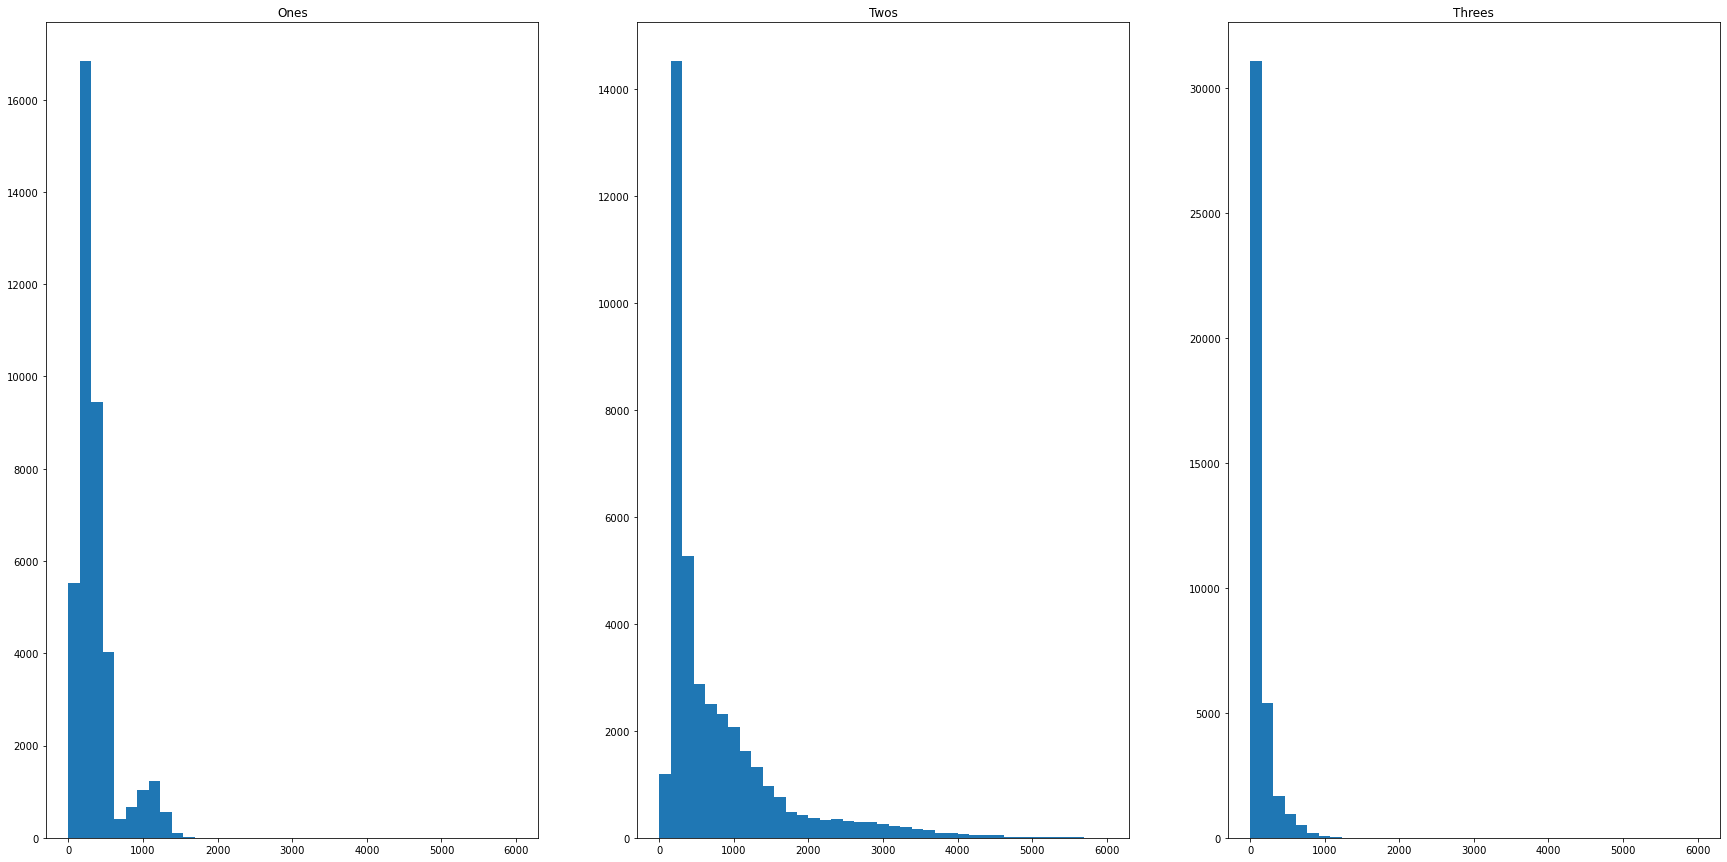

In [31]:
# Plot the counts of each call
threes = np.sum(variants_joined.X.toarray() == 3, axis=1)
twos = np.sum(variants_joined.X.toarray() == 2, axis=1)
ones = np.sum(variants_joined.X.toarray() == 1, axis=1)

plt.figure(figsize=(30, 15))

plt.subplot(131)
plt.title('Ones')
plt.hist(ones, bins=np.linspace(0, 6000, 40))

plt.subplot(132)
plt.title('Twos')
plt.hist(twos, bins=np.linspace(0, 6000, 40))

plt.subplot(133)
plt.title('Threes')
plt.hist(threes, bins=np.linspace(0, 6000, 40))

plt.show()

(array([24332.,  1668.,   640.,   346.,   210.,    91.,    33.,    62.,
           54.,    26.]),
 array([    0. ,  3981.6,  7963.2, 11944.8, 15926.4, 19908. , 23889.6,
        27871.2, 31852.8, 35834.4, 39816. ]),
 [<matplotlib.patches.Polygon at 0x7f25fc34c350>])

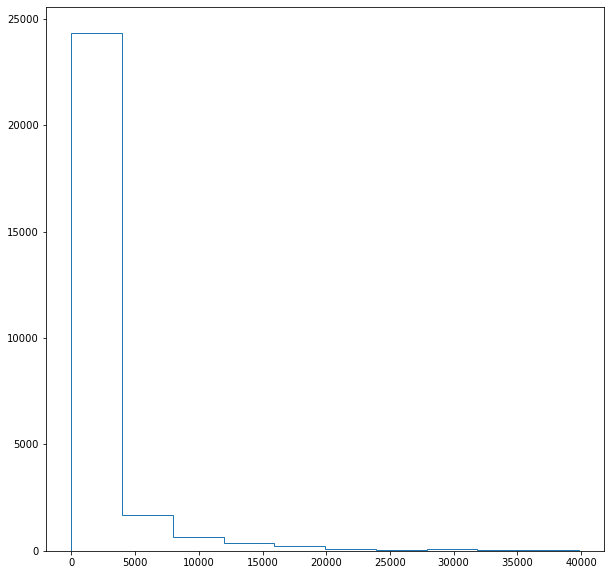

In [32]:
plt.figure(figsize=(10, 10))

variant_sums = np.array((variants_joined.X > 0).sum(axis=0))[0]
plt.hist(variant_sums, histtype='step')

In [33]:
def get_most_common_call(emb):
    counts = []

    for j in tqdm(range(emb.X.shape[1])):
        # Restrict only to cells we have a call for
        calls_for_variant = emb.X[:, j].flatten()
        calls_for_variant = calls_for_variant[calls_for_variant > 0]

        counts.append(np.bincount(calls_for_variant))

    # Find the most common call
    most_common_call = []

    for count in tqdm(counts):
        # If we have any calls for the variant, find the most common one
        if len(count > 0):
            most_common_call.append(np.argmax(count))
        else:
            most_common_call.append(0)

    most_common_call = np.array(most_common_call)
    
    return most_common_call

In [35]:
def find_differences(emb, most_common_call):
    ham_dists = []

    # Now go through each cell and see how many times we deviate from the most common call
    for i in range(emb.shape[0]):
        # Get the profile of detected variants for the cell
        cell = emb.X[i].flatten()
        cell_detected_vars = cell > 0

        ham_dists.append(get_adj_ham_dist_dense(cell, most_common_call))
        
    return ham_dists

## Examine Coverage to Check Accuracy of Calls

In [36]:
REF_COV_MAT_PATHS = ['data/emb1/mouse_1_coverage.ref.mtx']
COV_MAT_PATHS = ['data/emb1/mouse_1_coverage.out.mtx']

In [51]:
# Load coverage matrices
emb1_ref_mat = mmread(REF_COV_MAT_PATHS[0])
emb1_var_mat = mmread(COV_MAT_PATHS[0])
emb1_calls_mat = mmread(VARIANT_MTX_PATHS[0]).toarray().T

# Make a joined matrix giving the total reads
emb1_joined_mat = (emb1_ref_mat + emb1_var_mat).toarray().T

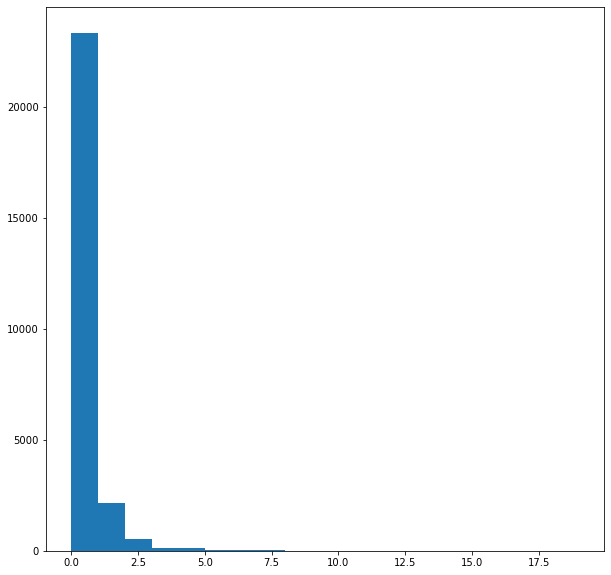

In [73]:
plt.figure(figsize=(10, 10))

avg_reads = emb1_joined_mat.sum(axis=0)/emb1_joined_mat.shape[0]
plt.hist(emb1_joined_mat[6], bins=range(20))
plt.show()

In [44]:
variants_joined[variants_joined.obs.embryo == 0, :]

View of AnnData object with n_obs × n_vars = 15361 × 27462
    obs: 'embryo'

## Filter Variants to only Highly Expressed Ones

In [20]:
new_embs = []
dists = []
most_common_calls = []

for emb_num in variants_joined.obs.embryo.unique():
    # Find the most common genotype for each embryo
    emb = variants_joined[variants_joined.obs.embryo == emb_num, :].copy()
    emb.X = emb.X.toarray().astype('int16')
    
    most_common_call = get_most_common_call(emb)
    most_common_calls.append(most_common_call)
    
    ham_dists = find_differences(emb, most_common_call)
    dists.append(ham_dists)
    
    # Get the best 10% of cells in terms of differing fraction
    cutoff = np.quantile(ham_dists, 0.01)
    emb_new = emb[ham_dists <= cutoff, :].copy()
    new_embs.append(emb_new)

  0%|          | 0/27462 [00:00<?, ?it/s]

  0%|          | 0/27462 [00:00<?, ?it/s]

  0%|          | 0/27462 [00:00<?, ?it/s]

  0%|          | 0/27462 [00:00<?, ?it/s]

  0%|          | 0/27462 [00:00<?, ?it/s]

  0%|          | 0/27462 [00:00<?, ?it/s]

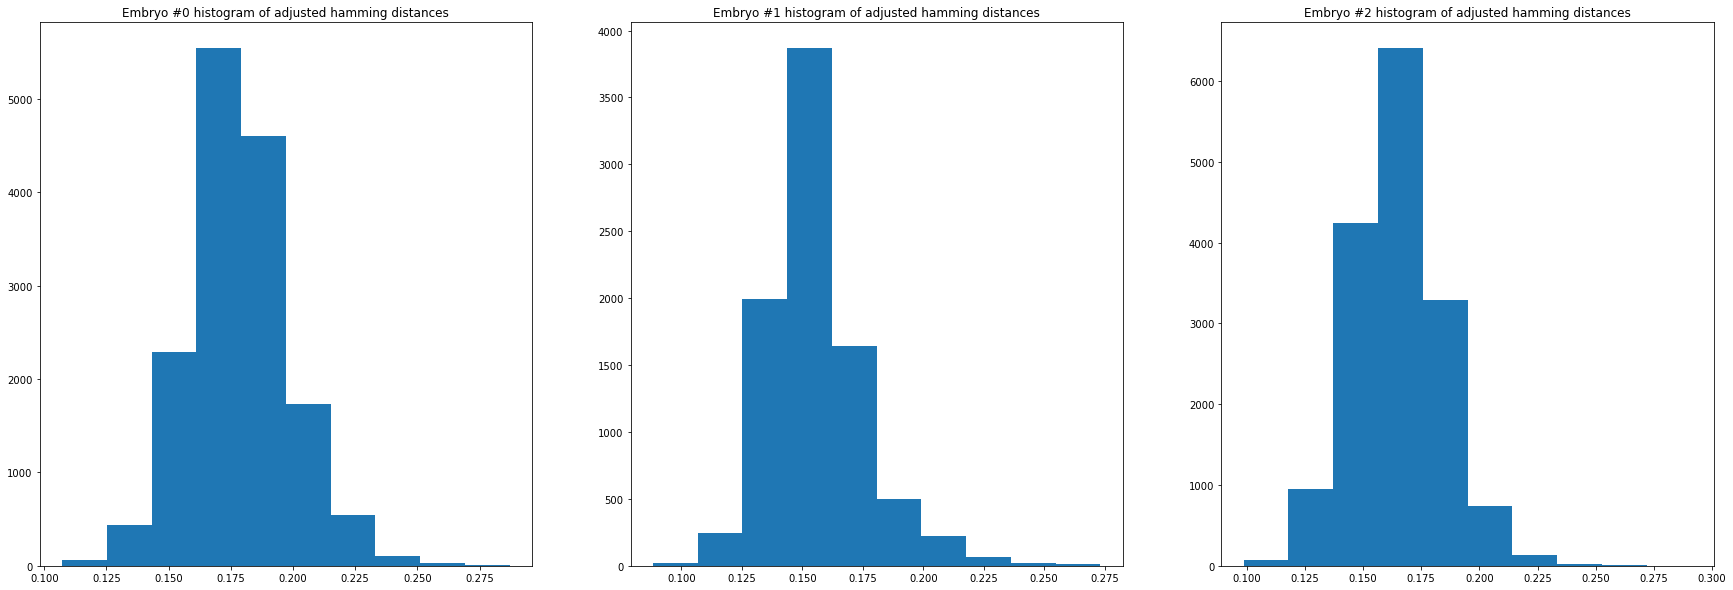

In [24]:
plt.figure(figsize=(30, 10))

for i in range(NUM_EMBRYOS):
    plt.subplot(1, 3, i+1)
    plt.title(f'Embryo #{i} histogram of adjusted hamming distances')
    plt.hist(dists[i])

In [22]:
genotype_dists = []

for g1 in most_common_calls:
    dist_g1 = []
    
    for g2 in most_common_calls:
        dist_g1.append(get_adj_ham_dist_dense(g1, g2))
        
    genotype_dists.append(dist_g1)
    
genotype_dists = np.array(genotype_dists)

In [11]:
variants_joined = anndata.concat(new_embs)

## Compute Adjusted Hamming Distances and Cluster

In [16]:
def get_adj_ham_dist_dense(cell1, cell2):
    # Find the shared mutations on which we have a call
    shared_inds = (cell1 != 0) & (cell2 != 0)
    num_shared = np.sum(shared_inds)
    
    # Find the number of variants called differently
    dif_call = cell1[shared_inds] != cell2[shared_inds]
    num_dif = np.sum(dif_call)
    
    return num_dif/num_shared

# Computes the adj hamming distance between the given row_num and 
# all cells above the row_num
def compute_dist_row(row_num):
    global mtx
    
    num_cells = mtx.shape[0]
    dists_row = np.zeros(num_cells)
    
    for i in range(row_num + 1, num_cells):
        dists_row[i] = get_adj_ham_dist_dense(mtx[row_num], mtx[i])
        
    return dists_row

# Computes the distance matrix using adjusted hamming distance
# Assumes rows are cells
def compute_adj_hamming_dists(num_cores=70):
    global mtx
    num_cells = mtx.shape[0]
    
    p = Pool(num_cores)
    dists = list(tqdm(p.imap(compute_dist_row, range(num_cells)), total=num_cells))
    p.close()
    
    dists = np.array(dists)
    
    return dists + dists.T

In [13]:
# We have to make the mtx global because partial doesn't work with
# such big data
#mtx = variants_joined.X.toarray()
mtx = variants_joined.X

dists = compute_adj_hamming_dists()
#del mtx

  0%|          | 0/475 [00:00<?, ?it/s]

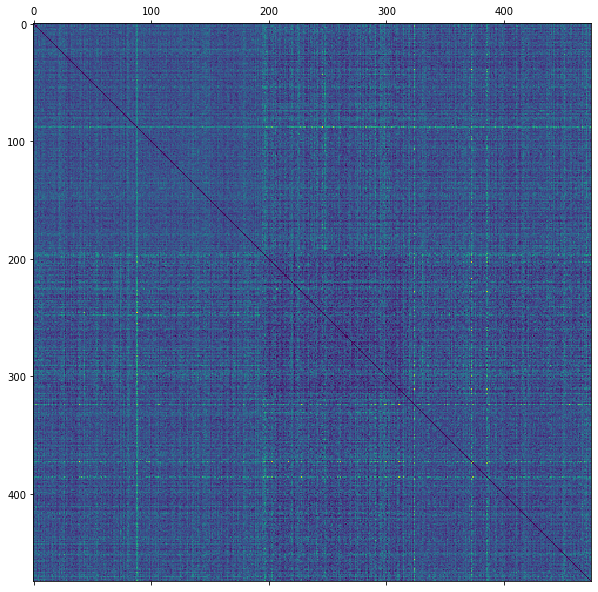

In [14]:
# Plot the distance matrix
plt.figure(figsize=(10, 10))
plt.matshow(dists, fignum=1)
plt.show()

In [15]:
# Get an affinity matrix from out dist matrix
X = np.exp(-dists)
#del dists
gc.collect()

19416

In [16]:
spectral_clusters = SpectralClustering(n_clusters=3, affinity='precomputed').fit(X)

In [17]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(variants_joined.obs.embryo, spectral_clusters.labels_)

0.28561330848416144